## Задание


ДЗ - оценить возраст человека по изображению. 

Применить механизм внимания (слой MultiheadAttention) вместо основного или вместе с основным телом модели. 
Цель - попробовать применять данный слой.  

In [32]:
import os
import sys
import wget
import shutil
import tarfile

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

print('OpenCV version ' + cv2.__version__)

OpenCV version 4.8.0


Загрузим файл с данными по ссылке (если файл не найден на диске)

In [33]:
def bar_custom(current, total, width=80):
    progress_msg = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write('\r' + progress_msg)
    sys.stdout.flush()

if not os.path.exists(DATA_FILE):
    wget.download(DATA_URL, DATA_FILE, bar=bar_custom)

Распакуем архив с набором данных в текущий каталог,
если каталог с данными еще не существует.

In [34]:
if not os.path.exists(DATA_FOLDER):
    tar = tarfile.open(DATA_FILE, 'r')
    tar.extractall()
    tar.close()

Выполним загрузку, проверку и обработку набора изображений из файлов

In [35]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Набор обработаных изображений для оценки возраста
cropped_images = pd.DataFrame(columns=['file_path', 'label'])

# Удалить каталог со старыми обработанными изображеним если существует, если нет - создать
if os.path.exists(os.path.join(DATA_FOLDER, 'cropped')):
    shutil.rmtree(os.path.join(DATA_FOLDER, 'cropped'), ignore_errors=True)

os.makedirs(os.path.join(DATA_FOLDER, 'cropped'))

IMG_SIZE = 64

img_valid=0 #счетчик всех корректных изображений
img_misloaded=0 #счетчик изображений с ошибками при загрузке
img_too_small=0 #счетчик изображений некорректного размера (1х1)
img_bad_faces=0 #счетчик изображений без лиц
img_bad_label=0 #счетчик изображений с некорретной оценкой класса

# Перебор всех вложенных элементов в указаном каталоге
for dir in tqdm(os.listdir(DATA_FOLDER)):
    # если вложенный элемент - каталог
    if os.path.isdir(os.path.join(DATA_FOLDER, dir)):
        # Перебор всех файлов в каталоге
        for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
            try:
                source_file_path = os.path.join(DATA_FOLDER, dir, file)

                # загрузить изображение и сконвертировать в монохромное
                img = Image.open(source_file_path).convert('L')
                img_array = np.array(img)

                # получить параметры изображения
                h, w = img_array.shape[:2]

                # если размер изображения меньше заданного - пропускаем
                if w < 128:
                    img_too_small+=1 
                    continue

                # выполняем детекцию лиц с максимально строгими настройками и минимальным размером лица 64х64
                face_rects1 = face_detector.detectMultiScale(img_array, scaleFactor=1.3, minNeighbors=6, minSize=(64,64))

                # оставляем только фото на которых есть только 1 лицо, остальные - пропускаем
                if len(face_rects1) != 1:
                    img_bad_faces+=1
                    continue  

               
    
                # формируем целевую метку изображения, как разность между вторым и первым годами в наименовании файла
                year_matched = re.findall(r'_(\d{4})', file)
                try:
                    label = int(year_matched[1]) - int(year_matched[0])
                except:
                    label = -1 
                
                # оставляем только изображения к меткой из заданного диапазона
                if (label < 1) | (label > 100):
                    img_bad_label+=1
                    continue

                # выполняем обрезку изображения по контуру лица и приведение к требуемому размеру
                x,y,h,w = face_rects1[0]
                img = img.crop((x, y, x+w, y+h)).resize((IMG_SIZE,IMG_SIZE), resample=Image.Resampling.BILINEAR)    

                # сохраняем обрезанное изображение в файл
                cropped_file_path = os.path.join(DATA_FOLDER, 'cropped', file)
                #cropped_images = cropped_images.append({'file_path': cropped_file_path, 'label': label}, ignore_index=True)
                cropped_images = pd.concat([cropped_images, pd.DataFrame([{'file_path': cropped_file_path, 'label': label}])], ignore_index=True)
                img.save(cropped_file_path)
                
                
            except Exception as ex:
                #print(ex)
                img_misloaded+=1
                print(ex)
                None # Если файл не удается прочитать - пропускаем его

print(f'Изображений с ошибками при загрузке {img_misloaded}')
print(f'Изображений с некорректными размерами {img_too_small}')
print(f'Изображений на которых не найдены лица {img_bad_faces}')
print(f'Изображений c некорректной меткой класса {img_bad_label}')

print(f'Всего корректных изображений {cropped_images.shape[0]}')

# Сохранить результат обработки данных в CSV-файл
cropped_images.to_csv('imdb_crops.csv')

 62%|██████▏   | 63/102 [06:49<04:32,  6.99s/it]

cannot identify image file '/mnt/c/Users/user/Documents/Python_Scripts/New_Andrey/DZ_43/wiki_crop/63/670663_2015-02-16UTC08'


100%|██████████| 102/102 [12:26<00:00,  7.32s/it]

Изображений с ошибками при загрузке 1
Изображений с некорректными размерами 40193
Изображений на которых не найдены лица 22109
Изображений c некорректной меткой класса 25
Всего корректных изображений 23667


In [36]:
cropped_images

,file_path,label
0,/mnt/c/Users/user/Documents/Python_Scripts/New...,67
1,/mnt/c/Users/user/Documents/Python_Scripts/New...,27
2,/mnt/c/Users/user/Documents/Python_Scripts/New...,43
3,/mnt/c/Users/user/Documents/Python_Scripts/New...,48
4,/mnt/c/Users/user/Documents/Python_Scripts/New...,25
...,...,...
23662,/mnt/c/Users/user/Documents/Python_Scripts/New...,55
23663,/mnt/c/Users/user/Documents/Python_Scripts/New...,27
23664,/mnt/c/Users/user/Documents/Python_Scripts/New...,59
23665,/mnt/c/Users/user/Documents/Python_Scripts/New...,52


In [45]:
import pandas as pd
# Укажите путь к вашему CSV файлу
csv_file_path = '/mnt/c/Users/user/Documents/Python_Scripts/New_Andrey/DZ_43/imdb_crops.csv'
# Чтение CSV файла
data = pd.read_csv(csv_file_path)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,file_path,label
0,/mnt/c/Users/user/Documents/Python_Scripts/New...,67
1,/mnt/c/Users/user/Documents/Python_Scripts/New...,27
2,/mnt/c/Users/user/Documents/Python_Scripts/New...,43
3,/mnt/c/Users/user/Documents/Python_Scripts/New...,48
4,/mnt/c/Users/user/Documents/Python_Scripts/New...,25


Отобразим произвольные 40 файлов изображений из набора обработанных данных

<Axes: >

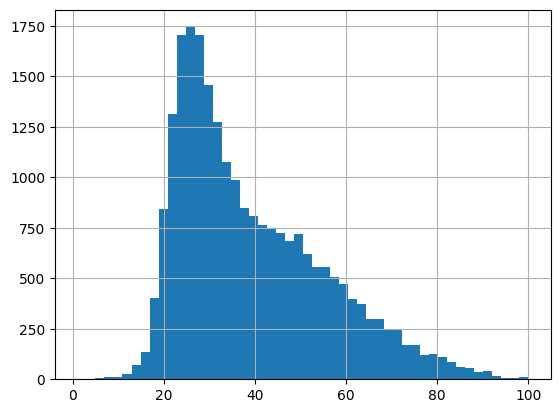

In [37]:
cropped_images['label'].hist(bins=50)

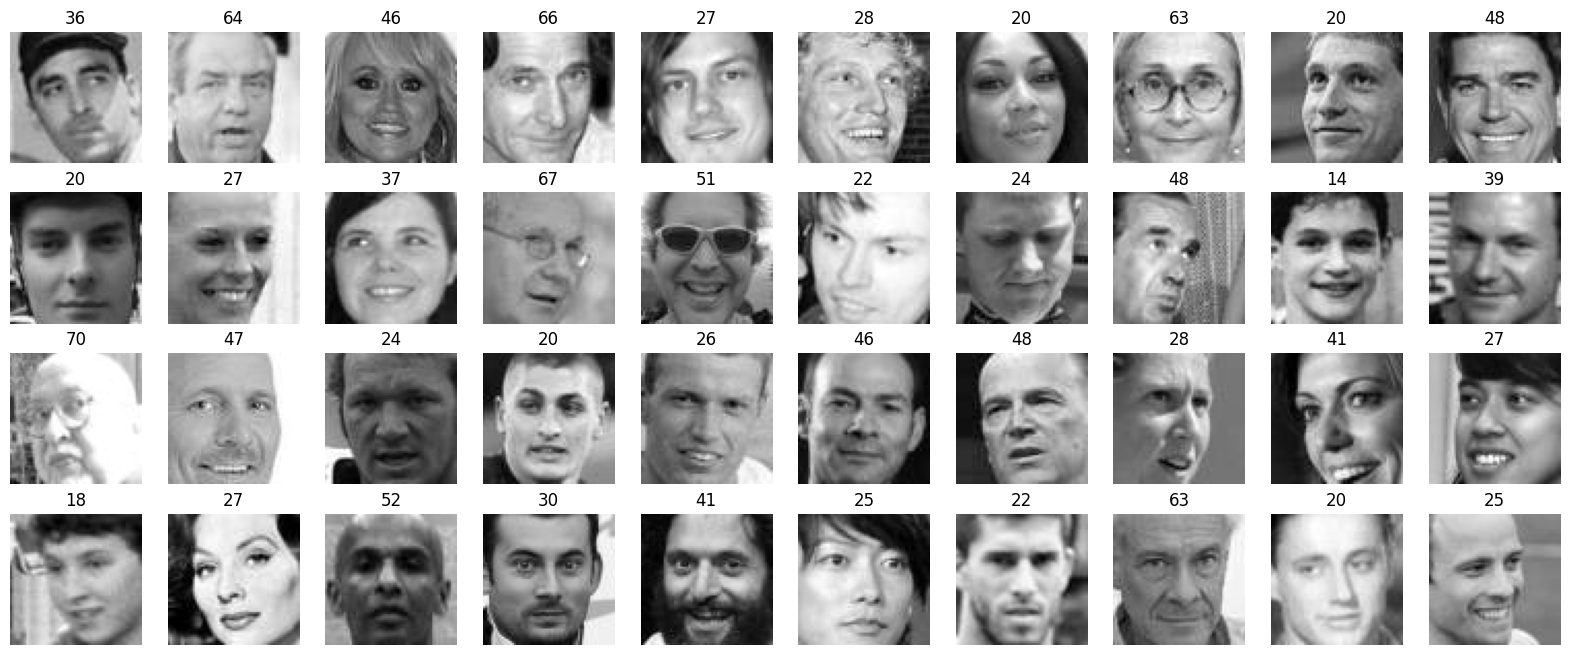

In [46]:
df = data
fig, ax = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
    for j in range(10):
        idx = np.random.choice(range(df.shape[0]))
        file, label = df.iloc[idx].file_path, df.iloc[idx].label
        ax[i, j].imshow(plt.imread(file), cmap='gray')
        ax[i, j].set_title(label)
        ax[i, j].axis('off')

---

In [47]:
data.head()

,file_path,label
0,/mnt/c/Users/user/Documents/Python_Scripts/New...,67
1,/mnt/c/Users/user/Documents/Python_Scripts/New...,27
2,/mnt/c/Users/user/Documents/Python_Scripts/New...,43
3,/mnt/c/Users/user/Documents/Python_Scripts/New...,48
4,/mnt/c/Users/user/Documents/Python_Scripts/New...,25


In [48]:
data['label'] = data['label'].astype(np.int32)

**Разделим данные на тренировочную, тестовую и валидационную выборку.**

In [49]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [51]:
TARGET_SIZE = (64,64)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="file_path",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="file_path",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
color_mode='rgb',
target_size=TARGET_SIZE)

Found 13254 validated image filenames.
Found 5679 validated image filenames.
Found 4734 validated image filenames.


# Определим и обучим несколько моделей.

**Custom model**

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D, GlobalAveragePooling2D, Input, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [53]:
tf.random.set_seed(42)

In [54]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="age_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

In [68]:
target_size = (64,64,3) 
input = Input(shape= target_size) 
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 
output = Dense(units=1, activation='linear')(x) 

model  = Model(input, output, name= 'Custom_Model')

In [74]:

model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['mae'])

In [75]:
model.summary()

Model: "Custom_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 128)      

In [77]:
history = model.fit(
                    train_generator, 
                    validation_data=valid_generator, 
                    epochs=20, 
                    callbacks=callbacks
                    )

Epoch 1/20
415/415 [==============================] - ETA: 0s - loss: 300.1381 - mae: 13.8224
Epoch 1: val_mae improved from 13.39700 to 13.36472, saving model to CustomModel.weights.hdf5
415/415 [==============================] - 115s 277ms/step - loss: 300.1381 - mae: 13.8224 - val_loss: 263.2194 - val_mae: 13.3647 - lr: 0.0010
Epoch 2/20
415/415 [==============================] - ETA: 0s - loss: 279.1452 - mae: 13.4932
Epoch 2: val_mae did not improve from 13.36472
415/415 [==============================] - 116s 279ms/step - loss: 279.1452 - mae: 13.4932 - val_loss: 264.6772 - val_mae: 13.6648 - lr: 0.0010
Epoch 3/20
415/415 [==============================] - ETA: 0s - loss: 272.8358 - mae: 13.3702
Epoch 3: val_mae improved from 13.36472 to 12.85939, saving model to CustomModel.weights.hdf5
415/415 [==============================] - 116s 279ms/step - loss: 272.8358 - mae: 13.3702 - val_loss: 292.8045 - val_mae: 12.8594 - lr: 0.0010
Epoch 4/20
415/415 [==============================]

In [80]:
test_loss = model.evaluate(test_generator)

148/148 [==============================] - 24s 163ms/step - loss: 152.2511 - mae: 9.1582


**Модель со слоем MultiHeadAttention.**

In [89]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Activation, GlobalMaxPool2D,GlobalAveragePooling2D, Input, MaxPool2D, MultiHeadAttention
# Задаем параметры сети
input_shape = (64,64,3) 

# Создаем сверточную нейронную сеть
input_layer = Input(shape=input_shape)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer) 
x = MaxPool2D(2,2)(input_layer) 

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 

x = Conv2D(filters=256, kernel_size=(3,3), activation='relu')(x) 
x = MaxPool2D(2,2)(x) 
x = GlobalMaxPool2D()(x)
x = Dropout(0.25)(x) 
x = Flatten()(x) 
x = Dense(units=128, activation='relu')(x) 
x = Dense(units=64, activation='relu')(x) 

# Создаем слой механизма внимания
x = MultiHeadAttention(num_heads=8, key_dim=512, attention_axes=(0, 1))(x, x)
x = Dropout(0.5)(x)

# Добавляем выходной слой
output_layer = Dense(1, activation='linear')(x)

In [90]:
# Создаем модель
mh_at_custom_model = Model(inputs=input_layer, outputs=output_layer)
mh_at_custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 max_pooling2d_26 (MaxPooli  (None, 32, 32, 3)            0         ['input_6[0][0]']             
 ng2D)                                                                                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 30, 30, 64)           1792      ['max_pooling2d_26[0][0]']    
                                                                                                  
 max_pooling2d_27 (MaxPooli  (None, 15, 15, 64)           0         ['conv2d_28[0][0]']     

In [92]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="mh_at_custom_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]

In [93]:
mh_at_custom_model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['mae'])

In [94]:
history = mh_at_custom_model.fit(
                    train_generator, 
                    validation_data=valid_generator, 
                    epochs=20, 
                    callbacks=callbacks
                    )

Epoch 1/20
415/415 [==============================] - 105s 250ms/step - loss: 340.1061 - mae: 14.5357 - val_loss: 266.7676 - val_mae: 13.4721
Epoch 2/20
415/415 [==============================] - 103s 249ms/step - loss: 298.1656 - mae: 13.8568 - val_loss: 279.6459 - val_mae: 13.0264
Epoch 3/20
415/415 [==============================] - 103s 248ms/step - loss: 296.5875 - mae: 13.8204 - val_loss: 266.4610 - val_mae: 13.3029
Epoch 4/20
415/415 [==============================] - 103s 248ms/step - loss: 292.8520 - mae: 13.7369 - val_loss: 266.4801 - val_mae: 13.2997
Epoch 5/20
415/415 [==============================] - 102s 246ms/step - loss: 292.9016 - mae: 13.8098 - val_loss: 281.7133 - val_mae: 13.0145
Epoch 6/20
415/415 [==============================] - 103s 249ms/step - loss: 294.0648 - mae: 13.7857 - val_loss: 266.1942 - val_mae: 13.3360
Epoch 7/20
415/415 [==============================] - 102s 247ms/step - loss: 289.3360 - mae: 13.7351 - val_loss: 269.0563 - val_mae: 13.1664
Epoch 

In [96]:
mh_at_custom_model = tf.keras.models.load_model('mh_at_custom_model.h5')

In [97]:
mh_at_custom_model.evaluate(test_generator)

148/148 [==============================] - 22s 151ms/step - loss: 276.9725 - mae: 13.6426


[276.97247314453125, 13.64262580871582]